# Tarea 7

### Fecha *límite* de entrega: **miércoles 14 de octubre de 2015**

Resuelve los siguientes problemas usando un método adecuado.

**1. El gato y el ratón**

Un gato, con posición es $\vec{r}_{G}$ y
velocidad $\vec{v}_{G}$, persigue a un ratón, con posición $\vec{r}_{R}$ y velocidad  $\vec{v}_{R}$. El gato corre directamente hacia
el ratón y, por lo tanto, su velocidad está dada por

$$\frac{\vec{v}_{G}(t)}{v_{G}(t)} 
=\frac{\vec{r}_{R}(t) - \vec{r}_{G}(t)} {\| \vec{r}_{R}(t) - \vec{r}_{G}(t) \|}$$

Dada la trayectoria del ratón y la rapidez del gato, ¿qué
camino sigue este último? Consideraremos dos casos, en los cuales la
rapidez de ambos es constante.

### Solución
En este problema, la trayectoria del ratón está conocida, así que solo hay que encontrar la trayectoria del gato. Así, las ecuaciones diferenciales adecuadas son:

$$
r_G' = |v_G| \frac{r_R - r_G}{||r_R - r_G||}
$$

Es decir, es una ecuación diferencial (vectorial) de primer orden. Lo que haremos primero será usar los resultados de la tarea 06 para definir los métodos de integración:

In [43]:
# Cualquiera de las funciones individuales relacionadas a los métodos de integración aceptará una celda
# de la forma {x_n, t_n}, donde x_n es un vector de por sí. Después, lo modificará en su lugar para no tener que pasar
# valores.

function euler_update!(values, f, h)
    values[1] += h*f(values) # Modificamos el vector
    values[2] += h # Movemos el tiempo
end;

function rk2_update!(values, f, h)
    k1 = f(values)
    k2 = f({values[1] + h * k1/2, values[2] + h/2})
    
    # Actualizamos el vector de estado
    values[1] += h*k2;
    values[2] += h;
end;

function rk4_update!(values, f, h)
    k1 = f(values)
    k2 = f({values[1] + h * k1 / 2, values[2] + h/2})
    k3 = f({values[1] + h * k2 / 2, values[2] + h/2})
    k4 = f({values[1] + h * k3, values[2] + h})
    
    # Actualizamos el vector de estado
    values[1] += h/6 * (k1 + 2*k2 + 2*k3 + k4);
    values[2] += h;
end;

# Esta función acepta una función de corte que se aplica al estado actual. Cuando esta función regresa false,
# la simulación se detiene.
function integrar_corte(cond_iniciales, h, funcion_corte::Function, f, metodo=rk4_update!)
    estado = deepcopy(cond_iniciales) # Inicializamos el estado
    
    t_values = [estado[2]]
    x_values = estado[1]
    
    while funcion_corte(estado) # Iteramos hasta llegar al final
        metodo(estado, f, h);
        
        # Agregamos un punto a la trayectoria
        t_values = vcat(t_values, estado[2])
        x_values = vcat(x_values, estado[1])
    end
    
    return {t_values, x_values};
end

integrar_corte (generic function with 2 methods)

Con esto hecho, ahora definimos la función de evolución para el gato:

In [44]:
# Esta función acepta una celda de estado {[x_gato y_gato], t}, la trayectoria del ratón 
# y la velocidad del gato
function f_gato(state, f_raton, vel_gato=1)
    t = state[2]
    r_gato = state[1][:, 1:2]
    r_raton = f_raton(t)
    distancia = (r_raton - r_gato)/norm(r_gato - r_raton)
    
    return vel_gato * distancia
end

f_gato (generic function with 2 methods)

Y finalmente, definimos una función de corte que corta la integración si el gato alcanza al ratón o si se llega a un tiempo límite

In [45]:
function corte_atrapar(state, f_raton, tlim=100)
    t = state[2]
    r_gato = state[1][:, 1:2]
    r_raton = f_raton(t)
    
    return (norm(r_gato - r_raton) > 0.01)  && (t < tlim)
end

corte_atrapar (generic function with 2 methods)

1. Inicialmente el ratón está en el origen del sistema de
  coordenadas y el gato está en un punto $(x_{0},y_{0})$. El ratón
  corre a lo largo del eje $x$ y el gato lo persigue. Muestra que el
  gato atrapa al ratón si $v_{G} > v_{R}$, mientras que si corren con
  la misma rapidez nunca lo atrapa.

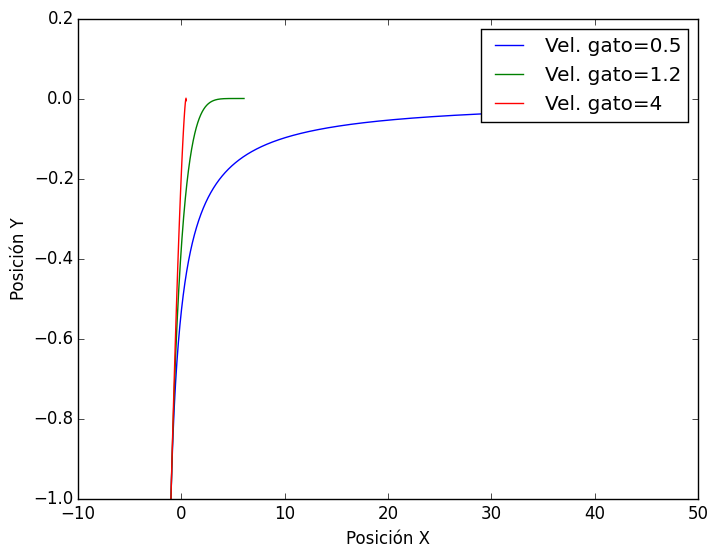

PyObject <matplotlib.legend.Legend object at 0x7f141d565278>

In [46]:
using PyPlot;
### Solución
# Primero definimos la función de trayectoria del ratón. Sin pérdida de generalidad, podemos hacer que corra 
# con velocidad unitaria
f_raton_lin(t) = [t 0];

# Definimos las condiciones iniciales (el gato en (-1,-1) en tiempo 0)
iniciales = {[-1 -1], 0}

# Creamos el juego de velocidades del gato
velocidades_gato = {0.5, 1.2, 4}

# Y para cada una, vemos la trayectoria
for vel_gato in velocidades_gato
    trayectoria = integrar_corte(iniciales, 0.01, (x -> corte_atrapar(x, f_raton_lin)), (x -> f_gato(x, f_raton_lin, vel_gato)))
    x_vals = trayectoria[2][:, 1]
    y_vals = trayectoria[2][:, 2]
    
    plot(x_vals, y_vals, label="Vel. gato=$vel_gato")
end

xlabel("Posición X")
ylabel("Posición Y")
legend()

2. Inicialmente el ratón está en el perímetro de un círculo, en
  cuyo centro está el gato. El ratón corre sobre el perímetro del
  círculo con rapidez $v_{R}$ y el gato lo persigue. Muestra que si $v_{G} \geq
  v_{R}$, el gato atrapará al ratón.

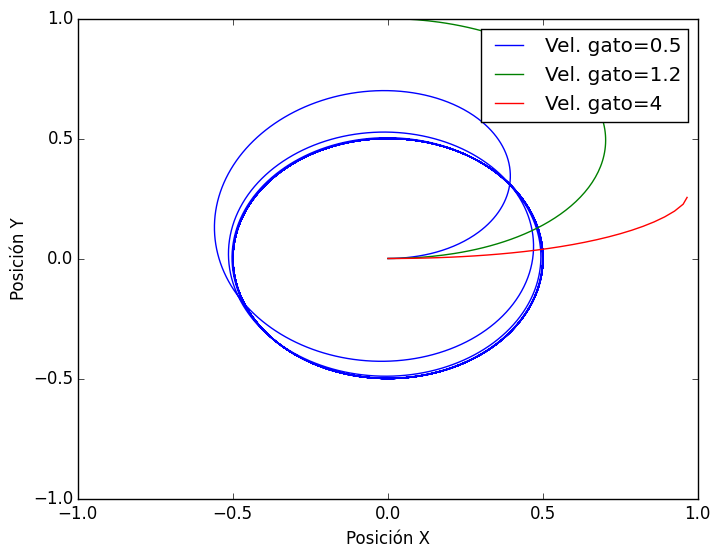

PyObject <matplotlib.legend.Legend object at 0x7f141d4d3ba8>

In [47]:
### Solución
# Análogamente al caso anterior:

# Primero definimos la función de trayectoria del ratón. Sin pérdida de generalidad, podemos hacer que corra 
# con velocidad unitaria
f_raton_cir(t) = [cos(t) sin(t)];

# Definimos las condiciones iniciales (el gato en (0,0) en tiempo 0)
iniciales = {[0 0], 0}

# Creamos el juego de velocidades del gato
velocidades_gato = {0.5, 1.2, 4}

# Y para cada una, vemos la trayectoria
for vel_gato in velocidades_gato
    trayectoria = integrar_corte(iniciales, 0.01, (x -> corte_atrapar(x, f_raton_cir)), (x -> f_gato(x, f_raton_cir, vel_gato)))
    x_vals = trayectoria[2][:, 1]
    y_vals = trayectoria[2][:, 2]
    
    plot(x_vals, y_vals, label="Vel. gato=$vel_gato")
end

xlim(-1, 1)
ylim(-1, 1)
xlabel("Posición X")
ylabel("Posición Y")
legend()

En cada caso, dibuja en una sola gráfica la trayectoria que sigue cada uno para tres valores de la rapidez del gato y una rapidez fija del ratón.

**2. Una carrera singular**

Dos bloques de masa $m_1$ y $m_2$ están unidos por una cuerda sin masa mediante una polea sin masa. El bloque 1 se mueve sobre una mesa de aerohockey, sin fricción. El bloque 2 se mueve como un péndulo, tal que la longitud de su cuerda cambia con el tiempo. Sus posiciones iniciales y el diagrama de cuerpo libre al tiempo $t$ se muestran a continuación:

|![diagrama](tarea07_figuras/conf_inicial.png)|![diagrama](tarea07_figuras/cuerpo_libre.png)|
|:---:|:---:|
|Configuración inicial|Diagrama de cuerpo libre|

A partir de la configuración inicial se tiene la restricción

$$
-x(t) + r(t) = 2d.
$$

Las ecuaciones de movimiento del bloque 2 son:

$$
\begin{array}{l}
\ddot{r} = \frac{m_2}{m_1 + m_2}(r\dot{\theta}^2 + g\cos\theta)\\
\ddot{\theta} = -\frac{1}{r}(2\dot{r}\dot{\theta} + g\sin\theta)
\end{array}
$$

Algo muy importante de lo que no hemos hablado en clase es el adimensionalizar las ecuaciones de movimiento. Esto es útil para la solución numérica, porque resulta en un reescalamiento de las variables físicas como tiempo, distancia, masa, carga, etc. a cantidades $\mathcal{O}(1)$. Por ejemplo, si normalizamos la masa en términos de la masa del electrón $m_e$, en lugar de hacer cálculos con números $\sim 10^{-31}$, lo cual requiere precisión arbitraria y da lugar a errores de redondeo importantes, la masa es un múltiplo entero de $m_e$. En la práctica, esto sirve para diseñar coches y aviones usando modelos a escala y no los objetos de tamaño real. Las cantidades adimensionales se calculan usando el [Teorema Pi de Buckingham](http://en.wikipedia.org/wiki/Buckingham_%CF%80_theorem).

Definiendo las variables adimensionales

$$
\rho = r/d, \quad \tau = t/t_0 \;\text{con}\; t_0 = \sqrt{d/g}, \quad \mu=m_1/m_2, 
$$

las ecuaciones de movimiento se vuelven las siguientes:

$$
\begin{array}{l}
\rho'' = \frac{1}{\mu+1}(\rho\theta'^2 + \cos\theta)\\
\theta'' = -\frac{1}{\rho}(2\rho'\theta' + \sin\theta).
\end{array}
$$

La energía total del sistema en términos de variables adimensionales es:

$$
E/E_0 = (K_1 + K_2 + U_2)/E_0, \quad E_0 = m_2gd
$$

con ($\nu = \rho', \omega = \theta'$)

$$
\begin{array}{l}
K_1/E_0 = \frac12 \mu\nu^2\\
K_2/E_0 = \frac12[\nu^2 + (\rho\omega)^2]\\
U_2/E_0 = -\rho\cos\theta
\end{array}
$$

### Solución:

La evolución para este sistema es

$$
\begin{aligned}
&\rho' = v_\rho \\
&v_\rho' = \frac{1}{\mu+1}(\rho v_\theta^2 + \cos\theta) \\
&\theta' = v_\theta \\
&v_\theta' = -\frac{1}{\rho}(2 v_\rho v_\theta + \sin\theta)
\end{aligned}
$$

En código:

In [48]:
### Función de evolución
function f_evol(state, μ=1)
    ρ = state[1][1]
    θ = state[1][2]
    v_ρ = state[1][3]
    v_θ = state[1][4]
    
    return [ v_ρ   v_θ   (ρ*v_θ^2 + cos(θ))/(μ+1)  -(2v_ρ * v_θ + sin(θ))/ρ ]
end

### Y la función de corte (cuando el bloque 2 toca la pared o el bloque 1 llega a la polea)
function corte_polea_pared(state)
    ρ = state[1][1]
    θ = state[1][2]
    
    return (ρ < 2) && (θ > 0)
end

corte_polea_pared (generic function with 1 method)

1. Considerando que las masas son iguales, $\mu = 1$, y que $\rho(0) = 1.0$, $\theta(0) = \pi/2$, $\nu(0) = \omega(0) = 0$, ¿qué sucede primero? ¿el bloque 1 llega a la polea? o ¿el bloque 2 llega a la pared? ¿A qué tiempo $\tau$ ocurre esto? Grafica $\rho(\tau)$, $\theta(\tau)$ y $x(\tau)$ usando [`subplot`](/tree/notas/subplot.ipynb). Si la cuerda mide 2 m, ¿cuánto tiempo es en segundos?

El tiempo normalizado cuando el bloque izquierdo toca la polea es 2.259999999999862
El tiempo físico (cuerda = 2m) cuando el bloque izquierdo toca la polea es 0.721930518449888 segundos


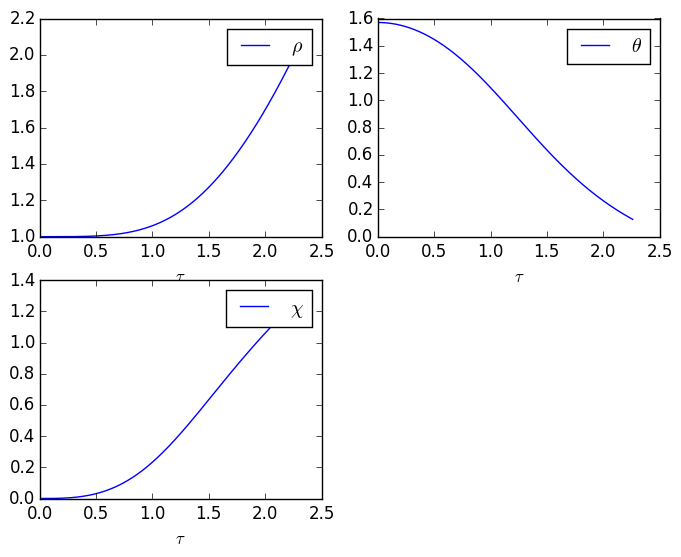

PyObject <matplotlib.legend.Legend object at 0x7f141d3cce10>

In [49]:
### Solución:

iniciales = {[1 π/2 0 0], 0}

trayectoria = integrar_corte(iniciales, 0.001, corte_polea_pared, f_evol)
print("El tiempo normalizado cuando el bloque izquierdo toca la polea es ")
println(trayectoria[1][end])

print("El tiempo físico (cuerda = 2m) cuando el bloque izquierdo toca la polea es ")
print(trayectoria[1][end] * sqrt(2/2 /9.8))
println(" segundos")

### Graficamos
subplot(2, 2, 1)
plot(trayectoria[1], trayectoria[2][:,1], label=L"\rho")
xlabel(L"\tau")
legend()

subplot(2, 2, 2)
plot(trayectoria[1], trayectoria[2][:,2], label=L"\theta")
xlabel(L"\tau")
legend()

subplot(2, 2, 3)
plot(trayectoria[1], trayectoria[2][:,3], label=L"\chi")
xlabel(L"\tau")
legend()

2. Para entender mejor este resultado, grafica el movimiento del centro de masa
$$
\frac{x_{\mathrm{cm}}}{d} = \frac{\rho(\mu + \sin\theta) -2\mu}{\mu + 1}.
$$
Explica físicamente lo que se obtiene.

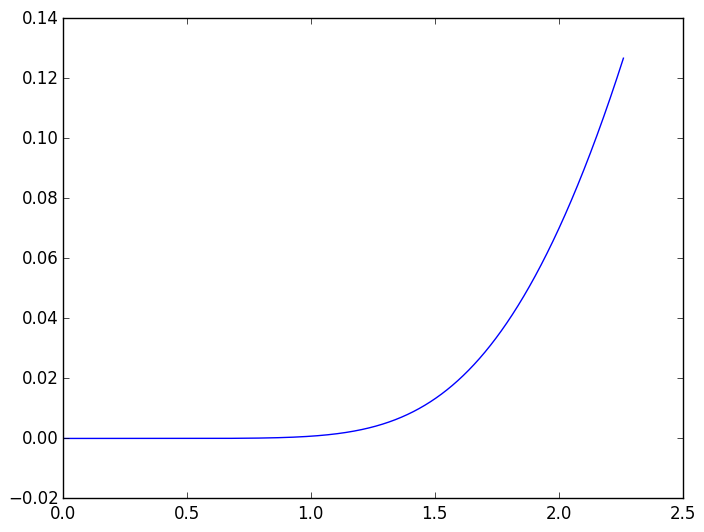

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f141d2d03c8>

In [50]:
### Solución:

# Definimos la función que se aplica al vector de estado y calcula la posición del centro de masa

function CM(x, μ=1)
    ρ = x[1]
    θ = x[2]
    
    return (ρ*(μ + sin(θ)) - 2μ)/(μ + 1)
end

# Y la aplicamos a la trayectoria calculada

plot(trayectoria[1], [CM(trayectoria[2][i,:]) for i in 1:size(trayectoria[2])[1]])

3. Dado que no hay disipación, muestra que la energía se conserva (aproximadamente). Grafica $K_1/E_0$, $K_2/E_0$, $U_2/E_0$ y $E/E_0$ en el mismo lienzo.

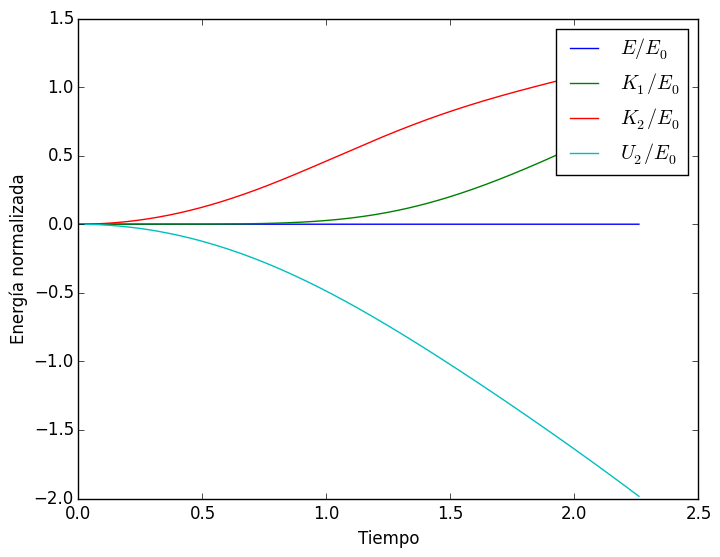

PyObject <matplotlib.text.Text object at 0x7f141d02c208>

In [58]:
## Esta función calcula las energias a partir de los vectores de estado de una
## trayectoria calculada y las regresa celdas

#K_1/E_0 = \frac12 \mu\nu^2\\
#K_2/E_0 = \frac12[\nu^2 + (\rho\omega)^2]\\
#U_2/E_0 = -\rho\cos\theta

function energia(state, μ=1)
    ρ = state[1]
    θ = state[2]
    ν = state[3]
    ω = state[4]
    return {1/2*μ * ν^2, 1/2 * (ν^2 + (ρ*ω)^2), -ρ * cos(θ)}
end

plot(trayectoria[1], [sum(energia(trayectoria[2][i,:])) for i in 1:size(trayectoria[2])[1]], label=L"E/E_0")
plot(trayectoria[1], [energia(trayectoria[2][i,:])[1] for i in 1:size(trayectoria[2])[1]], label=L"K_1/E_0")
plot(trayectoria[1], [energia(trayectoria[2][i,:])[2] for i in 1:size(trayectoria[2])[1]], label=L"K_2/E_0")
plot(trayectoria[1], [energia(trayectoria[2][i,:])[3] for i in 1:size(trayectoria[2])[1]], label=L"U_2/E_0")
legend()
xlabel("Tiempo")
ylabel("Energía normalizada")

4. Repite los incisos 1. y 2. para $\mu=2.0$. ¿Qué sucede? Explica.

5. Discretiza el intervalo $[1.0,2.0]$ de valores de $\mu$ y determina para qué valor se obtiene un empate. ¿Qué debes graficar para mostrar esto?

[Tarea escrita por Marduk Bolaños.]